# C - Flux Convolution

Objective
-
This notebook builds upon the preceding notebooks, `A-Differential-Neutron-Nucleus-XN.ipynb` and `B-Neutron-Nucleus-Recoil-Distributions.ipynb`. Our objective now is to calculate a realistic recoil energy spectrum—that is, a prediction of how frequently we expect to see recoils at various energies when neutrons interact with a silicon detector. This calculation depends on two factors:

Neutron Flux as a Function of Energy: The number of neutrons striking the detector material at each incident energy level.

Differential Cross Section for Neutron-Nucleus Scattering: The probability that a neutron of a given incident energy will cause a nucleus to recoil with a specific energy.

One specific recoil energy can be caused by many diferent incident neutron energies, depending on the two factors mentioned above. For example, a low-energy incident neutron colliding directly with a nucleus (small impact parameter) may yield the same recoil energy as a high-energy incident neutron colliding less directly with a nucleus (large impact parameter). We will therefore integrate over all incident neutron energies that can cause a given recoil energy. This will produce a calculation of how the energy distribution of the incident neutrons interacts with the detector's interaction probabilities, resulting in a measured recoil spectrum. This result is a flux-convolved recoil energy distribution, simulating what we would expect to measure in a detector.

Libraries and Style Files
-------------------------

In [1]:
#we may need some code in the ../python directory and/or matplotlib styles

# Add path to local Python modules (../python)
import sys
sys.path.append('../python/')

# Optional: Auto-install missing dependencies (for portability)
import importlib.util
import subprocess

def install_if_missing(pkg_name):
    if importlib.util.find_spec(pkg_name) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

install_if_missing("periodictable")
install_if_missing("pyteomics")

# Import standard libraries
import numpy as np
import pandas as pd
import scipy.constants as co
from scipy import integrate

# Plotting with a custom style
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

# Import project-specific modules
import ENDF6el as endfel
import masses as ms
import flux_recoil_spec as frs

Load Neutron Flux and Calculate Recoil Spectrum
-
This section will allow us to determine the likelihood of a neutron with energy $E_n$ scattering off a nucleus and depositing a certain amount of recoil energy $E_r$. This likelihood is given by the differential cross section $\frac{d\sigma}{dE_r}(E_n,E_r)$. In the previous notebook, `B-Neutron-Nucleus-Recoil-Distributions.ipynb`, we developed code that calculates this value for specific energies. Now, we want to generalize it. The following section will provide us with the expected distribution of nuclear recoil energies measured by the detector.

Neutrons interact with detectors at differing initial energies ($E_n$), and the number of incident neutrons at a given specific energy is described by the neutron flux spectrum, $\Phi(E_n)$. These neutrons recoil at varying energies ($E_r$) depending on factors including their incident energy and the collision's differential cross section $\frac{d\sigma}{dE_r}(E_n,E_r)$. The total rate at which these recoils happen is found by summing the contribution from all differentiaal neutron energies that could cause a recoil of that amount. In other words, we must sum over all neutron energies that can produce a specific recoil energy. Hence, we integrate. We will use the following equation to calculate the differential event rate per unit recoil energy:

$$
\frac{dR}{dE_r} = \int_{E_n^{\text{min}}}^{E_n^{\text{max}}} \Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r) \, dE_n
$$

Where:<br /><br />
$\frac{dR}{dE_r}$ is rate (per time, per mass) at which recoils of energy $E_r$ occur.<br />
$\Phi(E_n)$ is the flux at neutron energy $E_n$.<br />
$\frac{d\sigma}{dE_r}(E_n, E_r)$ is the differential recoil cross section at neutron energy $E_n$, which tells us the probability of measuring a recoil of $E_r$ from a neutron with incident energy $E_n$.

Thus, the integrand $\Phi(E_n) \cdot \frac{d\sigma}{dE_r}(E_n, E_r)$ gives us the rate at which neutrons of energy $E_n$ contribute to producing recoils of energy $E_r$.

We repeat this process for many values of $E_r$ to generate a full recoil spectrum.

In [2]:
# Define realflux Function using SNOLAB_flux
from scipy.interpolate import interp1d

# Load flux from the frs module
E, F, *_ = frs.SNOLAB_flux()  # E: energy [MeV], F: flux [n/cm^2/s/MeV]

# Create an interpolator (flux as a function of neutron energy)
flux_interp = interp1d(E, F, bounds_error=False, fill_value=0.0)

# Define realflux function to wrap the interpolator
def realflux(En):
    return flux_interp(En)

fast flux: 4000.0000000000005 n/m^2/day
175
shape of etot: (6000,)
6000 6000
LinregressResult(slope=-0.34198906017016933, intercept=-12.883178144228596, rvalue=-0.9953352356165472, pvalue=2.8473572672917526e-06, stderr=0.01482451947661301, intercept_stderr=0.06273875262265731)
0.009998654133395216 0.01


This grabs flux data (E, F), where E is a list of neutron energies and F is the measured flux at each energy. `interp1d` creates a smooth curve through the data points, and `realflux(En)` lets us evaluate the curve at any neutron energy.

In [3]:
# Constants
NA = co.physical_constants['Avogadro constant'][0]  # Avogadro's number

# Natural abundances and atomic masses of Si isotopes
si_isotopes = {
    (14, 28): {'abundance': 0.92223, 'mass': 27.9769265325},
    (14, 29): {'abundance': 0.04685, 'mass': 28.976494700},
    (14, 30): {'abundance': 0.03092, 'mass': 29.97377017},
}

# Energy range of recoil energies [keV]
erange = np.linspace(0.0, 20.0, 200)  # 0 to 20 keV

In [4]:
def dsigdEr(En, Er):
    # En in keV, Er in keV
    return frs.dsigdErNE(En, Er)

This function returns the differential cross section, i.e., how likely it is that a neutron of energy $E_n$ will produce a recoil energy $E_r$.

In [5]:
# Define reusable function outside the loop
def compute_dru_vector(Z, A, mass):
    def dru(Er):
        def integrand(En):
            flux = realflux(En)  # n/cm²/s/MeV
            sig = frs.dsigdErNE(En * 1e3, Er, (Z, A))  # ✅ pass (Z, A) tuple
            return flux * sig

        En_min = frs.Enmin(Er) / 1000  # MeV
        En_max = 10  # MeV

        integral, _ = integrate.quad(integrand, En_min, En_max, limit=1000)
        return Z * (NA / mass) * integral  # counts/g/s/keV

    return np.array([dru(e) for e in erange])

# Store dru spectra for each isotope
dru_dict = {}
for (Z, A), props in si_isotopes.items():
    mass = props['mass']
    dru_dict[(Z, A)] = compute_dru_vector(Z, A, mass)

This code converts energy units and integrates over neutron energies that can cause a specific recoil energy. The factor `14 * (NA / msi)` scales the rate to per gram of silicon. `integrate.quad` does the actual integration.

Now that we have defined the differential rate function $\frac{DR}{DE_r}$ — the number of recoils per second per gram per keV, we now want to compute it over a range of recoil energies.

`erange` is a list of recoil energies we want to investigate, ranging from 0 to 20 keV.

For each value e in `erange`, we call our `dru(e)` function, which:

Integrates over all neutron energies that could have caused a recoil of energy `e`.

Multiplies the neutron flux at each energy by the differential cross section $\frac{d\sigma}{dE_r}(E_n, E_r)$.

Returns the result as the expected rate of recoils at energy `e`, per gram of material, per second, per keV.

`dru_vec` ends up being an array of those recoil rates.

In [6]:
# Convert each isotope's spectrum to DRU [counts / kg / year / keV]
conversion = 1000 * 365 * 24 * 60 * 60  # g/s → kg/year

dru_dists_kg_yr = {}
for iso_key, dru_vec in dru_dict.items():
    dru_dists_kg_yr[iso_key] = dru_vec * conversion

We're converting from:

[counts / g / s / keV] to

[counts / kg / year / keV]

This makes our result more meaningful for real-world experiments, which often report detector rates per kilogram per year.

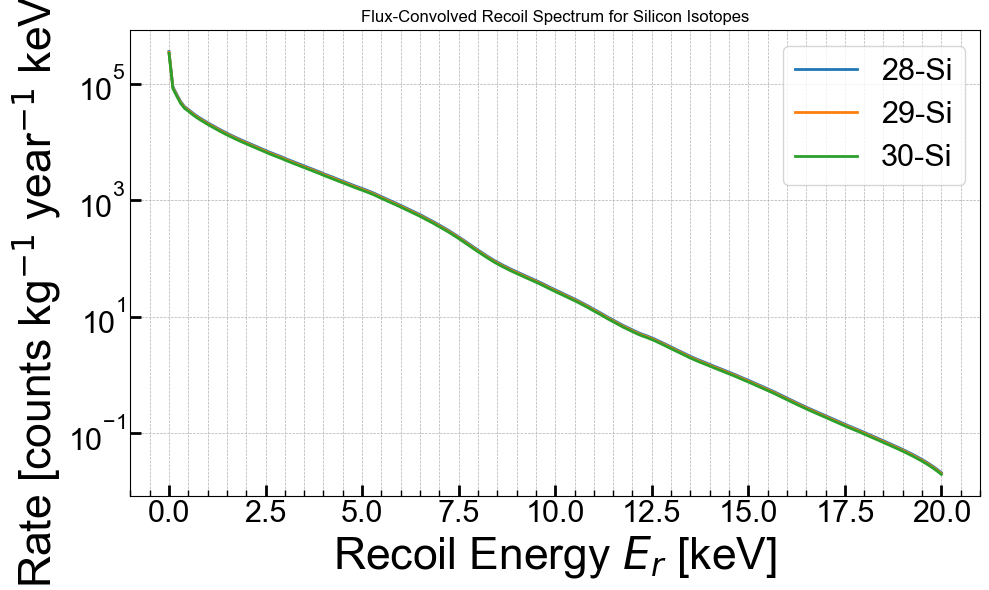

In [7]:
# Plot each isotope's flux-convolved recoil spectrum
plt.figure(figsize=(10, 6))

for (Z, A), dru_vec in dru_dists_kg_yr.items():
    plt.plot(erange, dru_vec, label=f"{A}-Si")

plt.yscale('log')
plt.xlabel(r'Recoil Energy $E_r$ [keV]')
plt.ylabel(r'Rate [counts kg$^{-1}$ year$^{-1}$ keV$^{-1}$]')
plt.title('Flux-Convolved Recoil Spectrum for Silicon Isotopes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

We code our plot with the following features:

X-axis: Recoil energy in keV — how much energy the silicon nucleus receives from the neutron.

Y-axis (log scale): Event rate per kg per year per keV — how often that kind of recoil would be detected.

Logarithmic scale on the Y-axis helps visualize values that span several orders of magnitude.

Grid and legend improve readability and clarity.

Plot Interpretation
-
This is the realistic recoil spectrum we'd expect to see in a silicon-28 based detector. The plot accounts for both the physical interaction (via the differential cross section) and the available neutrons at each energy (via the flux spectrum).

We can observe the following:

High counts at lower recoil energies: Most neutrons don't transfer a relatively large amount of energy per collision, so low-energy recoils are more common.

Exponential drop-off: As recoil energy increases, the likelihood of a neutron-nucleus collision yielding that recoil energy becomes less likely (due to kinematic limits and fewer high-energy neutrons).

Shape variations: Any bumps or features in the plot's curve may reflect real structures in the neutron flux spectrum or cross section features of silicon.